In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl

from src.visualization import plot_data


plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))

[PosixPath('../../../input/hms-harmful-brain-activity-classification/test_eegs'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/single'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/test.csv'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/example_figures'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/test_spectrograms'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/train_spectrograms'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/sample_submission.csv'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/train_eegs'),
 PosixPath('../../../input/hms-harmful-brain-activity-classification/train.csv')]

In [3]:
metadata = pl.read_csv(data_dir / "train.csv")

## 固有なデータの分布について

In [4]:
metadata["eeg_id"].unique().shape

(17089,)

In [5]:
metadata["spectrogram_id"].unique().shape

(11138,)

In [6]:
metadata["label_id"].unique().shape

(106800,)

調べる項目:

- uniqueな`eeg_id`の数
- `eeg_id` あたりの`eeg_sub_id`の数の分布
- `eeg_id` と `sprctrogram_id` の対応が1:1でないものが存在しないこと
- ラベルごとの分布(`seizure_vote`, `lpd_vote`, `gpd_vote`, `lrda_vote`, `grda_vote`, `other_vote`)

memo:

- 1つのEEG/spectrogramに対し、特定のoffsetについて50secの範囲を切り取って診断しているっぽい。前者は`eeg_id`/`spectrogram_id`で、後者は`eeg_sub_id`/`spectrogram_sub_id`で管理しているっぽい。
- 同じIDのEEGのグループ特徴とクローズアップしたsub-EEGの特徴を両方加味して診断を下しているっぽい(competition pageの説明にも「5secのEEGを見るとRDAだが、50secのspectrogramを見るとseizureの終わりのタイミングだから両方のラベルがついている」といった内容の記述がある。)

確認したい:

- EEG/spectrogramの範囲は完全に一致しているのか？

findings

- ノイズすごい -> rolling meanをとる
- データのrangeが広すぎる
    - 電極が外れたりしている？
    - まさかとは思うがオシロスコープのdynamicレンジの電圧をそのままデータとしている？


In [7]:
eeg_id = 1628180742
eeg = pl.read_parquet(data_dir / f"train_eegs/{eeg_id}.parquet")

In [8]:
eeg.head()

Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
-80.519997,-70.540001,-80.110001,-108.75,-120.330002,-88.620003,-101.75,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.92
-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.82,-104.260002,-99.730003,-99.07,-92.290001,-96.019997,-84.5,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.5,-102.059998,29.219999
-80.209999,-75.870003,-82.050003,-106.010002,-117.5,-87.489998,-99.589996,-96.82,-119.68,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.75,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.18,-128.940002,-109.889999,83.870003
-90.57,-80.790001,-93.0,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.93,-115.639999,-99.800003,-97.5,-88.730003,-114.849998,-100.25,97.769997


label_id=2788603758, eeg_id=1830813584, eeg_sub_id=0, spectrogram_id=814955625
spectrogram_offset_sec=0.0, eeg_offset_sec=0.0


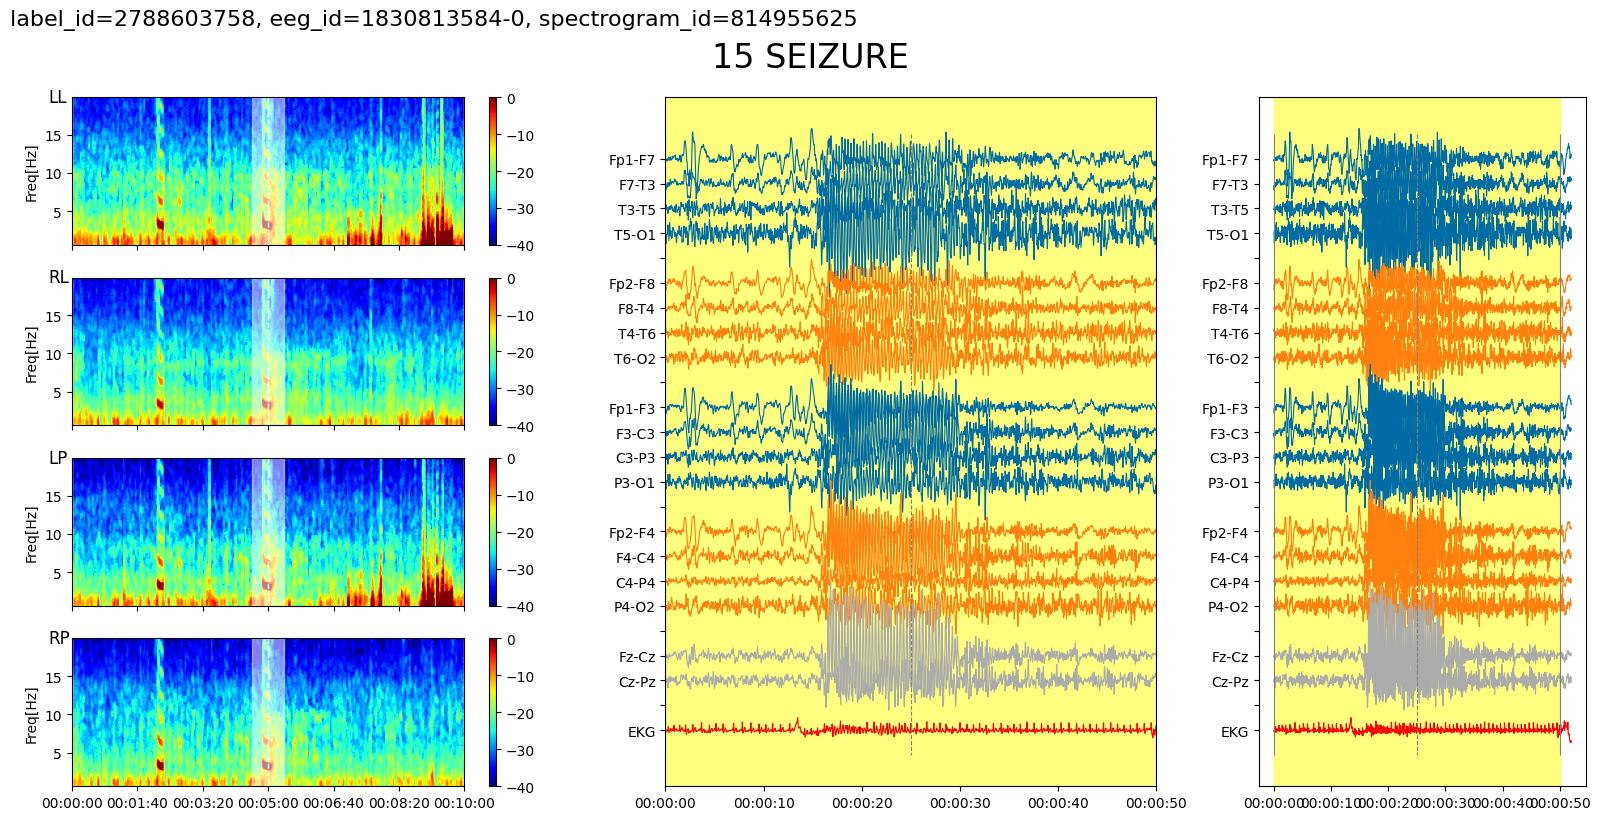

label_id=3260516868, eeg_id=876238217, eeg_sub_id=9, spectrogram_id=1420583958
spectrogram_offset_sec=1176.0, eeg_offset_sec=26.0


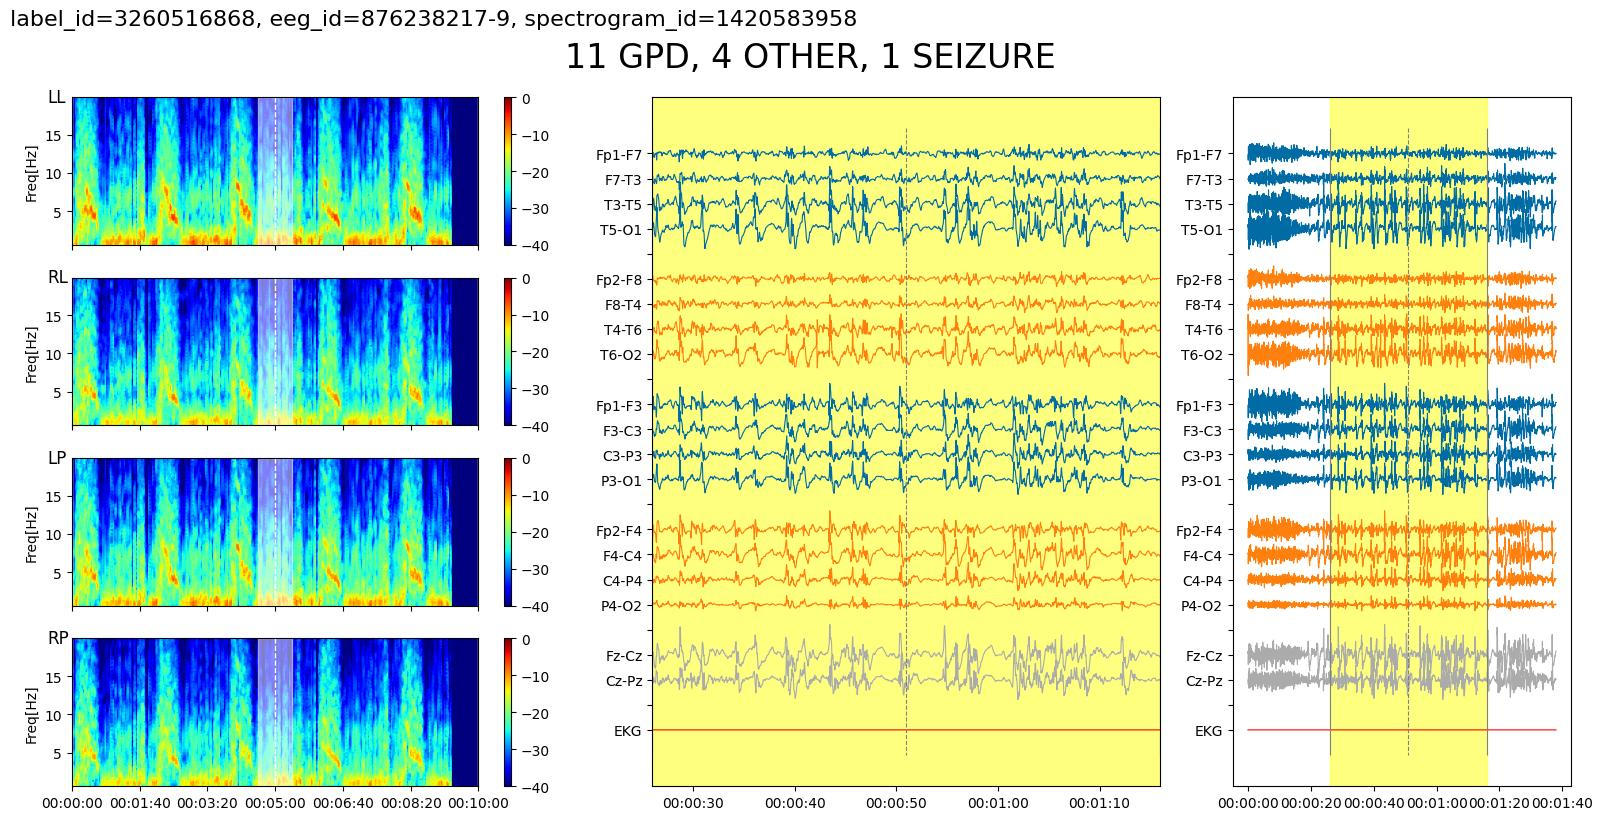

label_id=3076390564, eeg_id=3606469849, eeg_sub_id=0, spectrogram_id=1758670963
spectrogram_offset_sec=540.0, eeg_offset_sec=0.0


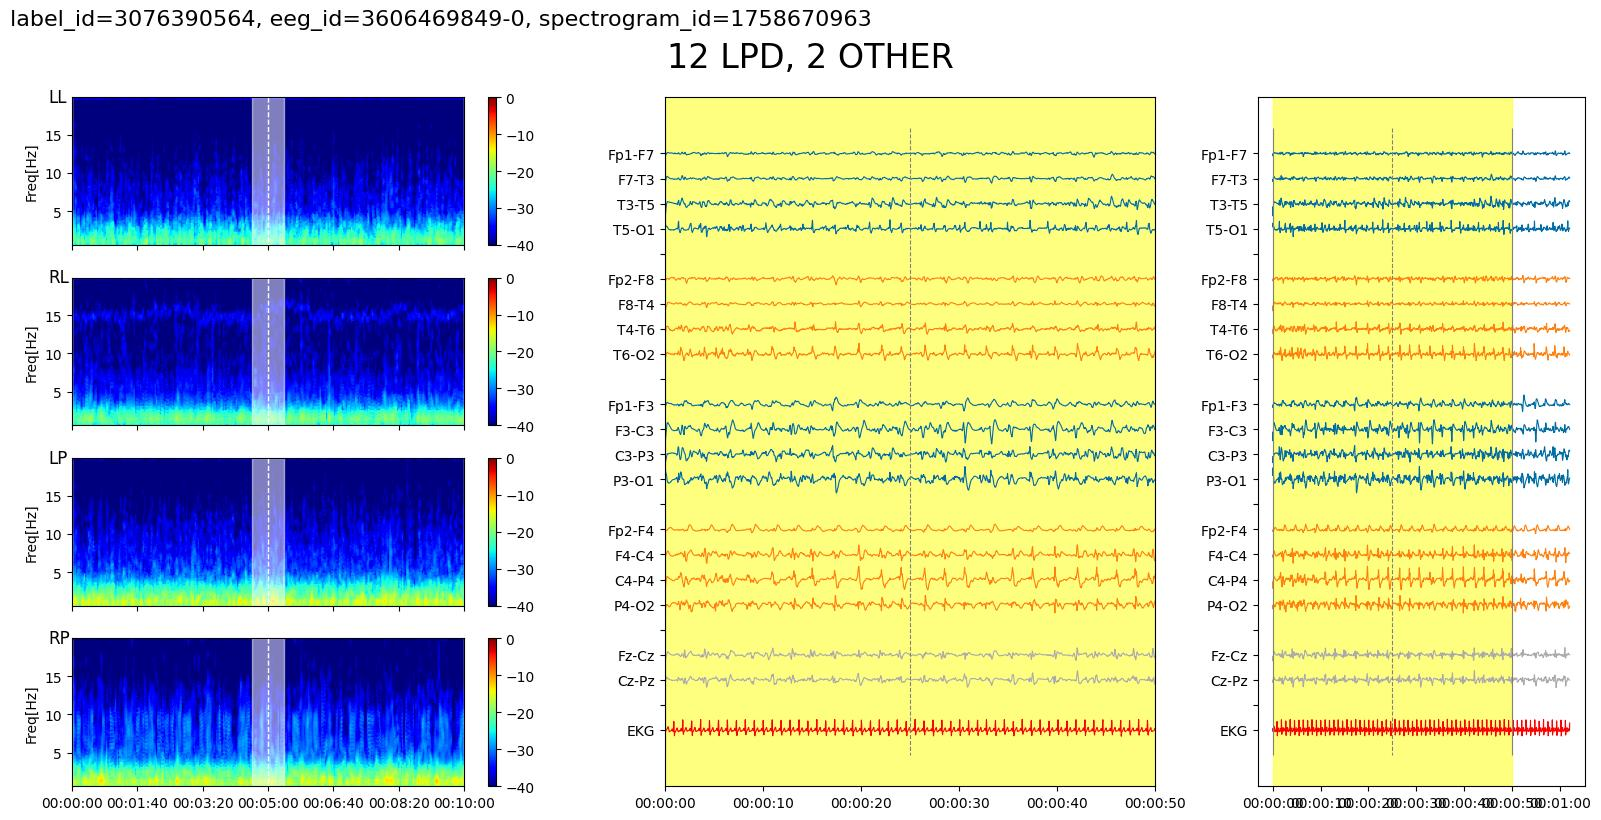

label_id=409156954, eeg_id=338161210, eeg_sub_id=2, spectrogram_id=804904703
spectrogram_offset_sec=4.0, eeg_offset_sec=4.0


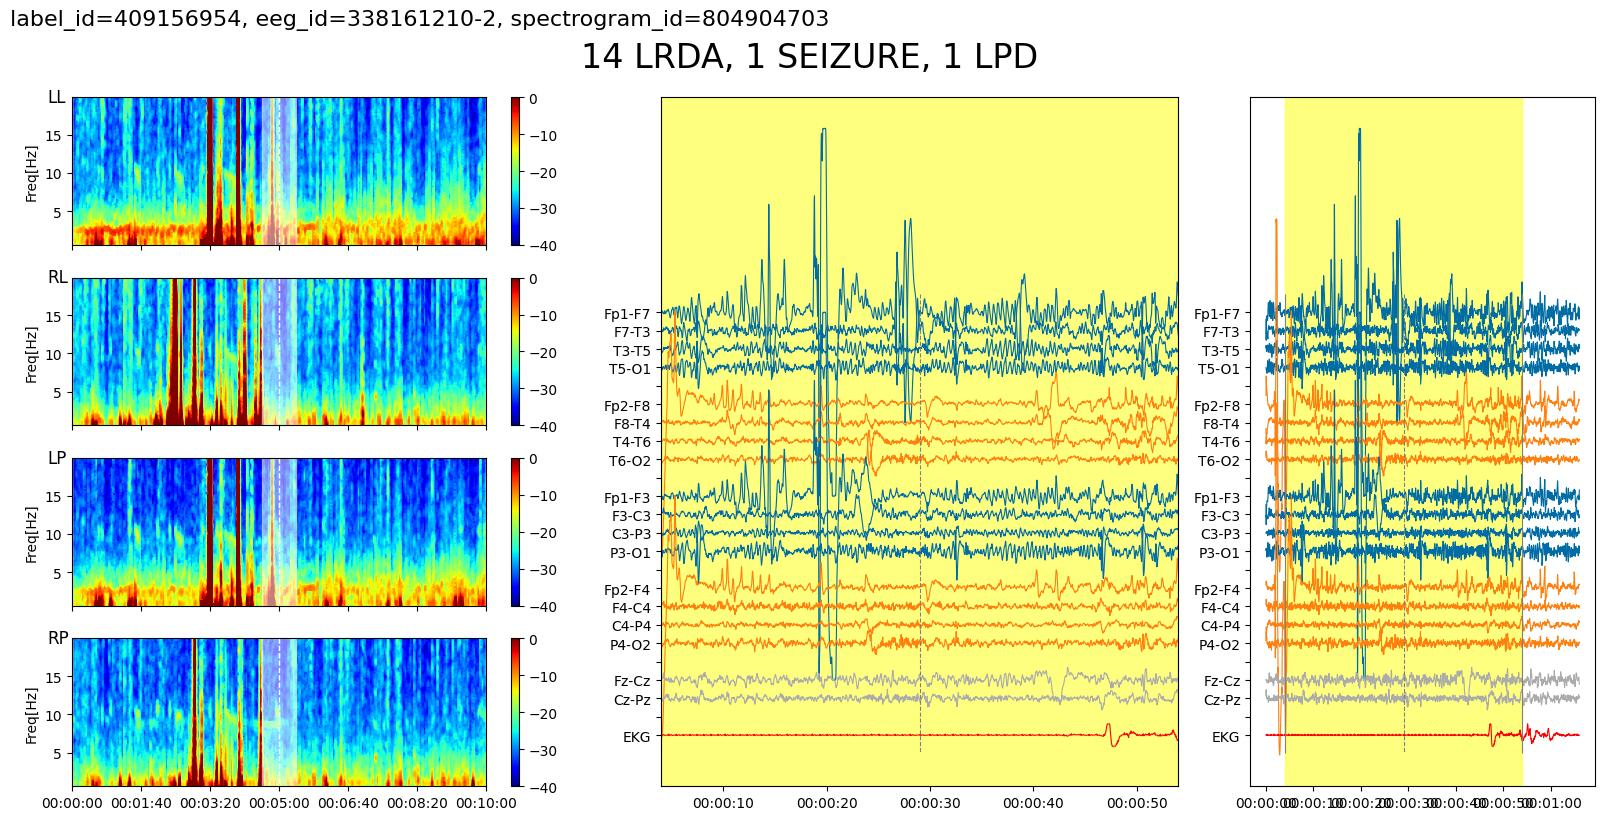

label_id=10144756, eeg_id=1171868086, eeg_sub_id=7, spectrogram_id=555474116
spectrogram_offset_sec=22.0, eeg_offset_sec=22.0


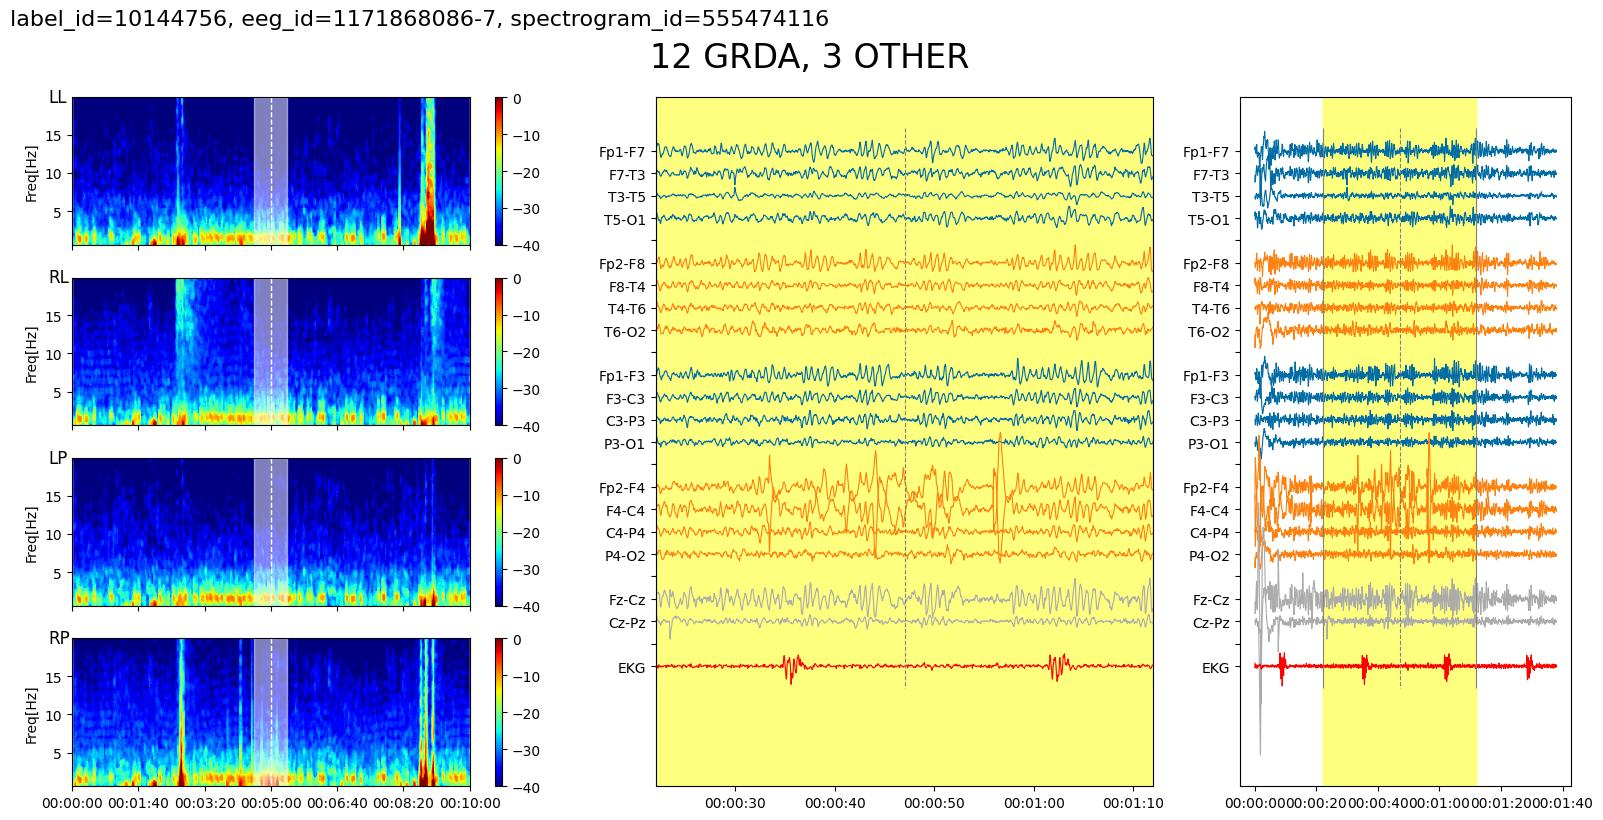

label_id=3768806886, eeg_id=574269039, eeg_sub_id=1, spectrogram_id=441561193
spectrogram_offset_sec=4.0, eeg_offset_sec=4.0


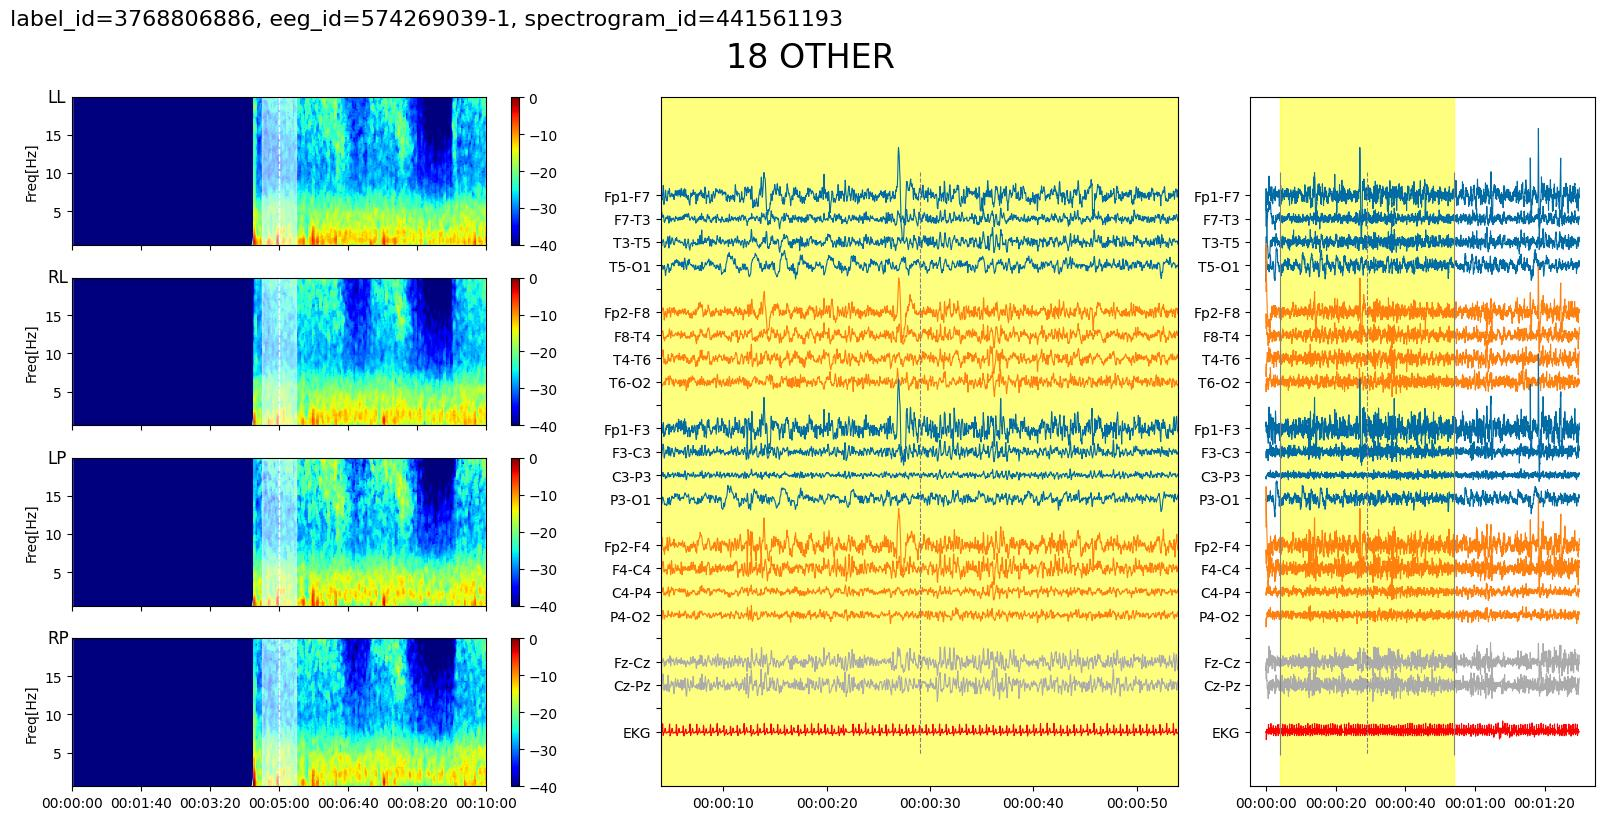

In [9]:
for label in ["seizure", "gpd", "lpd", "lrda", "grda", "other"]:
    row = metadata.filter(pl.col(f"{label}_vote").gt(10)).sample(1)
    eeg_id = row["eeg_id"][0]
    eeg_sub_id = row["eeg_sub_id"][0]
    plot_data(metadata, eeg_id, eeg_sub_id)
    plt.show()

TODO:

- probeごとのnoiseっぽさを表現する特徴を作る
    - rolling_std_in_n_sec
- probeごとの波形をプロットする関数の実装
- 特定のprobeが外れているかどうかを判定するには？

調査必要

- データの前処理方法を確認する(ホストに聞く + 論文に書かれてないか？)
- サンプルごとののダイナミックレンジを知りたい
- 一般的なEEGのPreprocessingについて確認する[1]

## Reference

- [1] http://learn.neurotechedu.com/preprocessing/
